<a href="https://colab.research.google.com/github/dayananikol/CCDATSCL_PROJECT_COM221ML/blob/main/DS_PROJECT4_separate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Title**

**Problem Statement**: I often find that my breaks take longer than planned, which delays my tasks and affects my focus afterward. However, it is unclear which factors contribute most to these break overshoots and how they impact my post-break focus. By analyzing my break behavior, including triggers, activities, task difficulty, and time of day, I aim to identify patterns that lead to overshoots and changes in focus, so I can improve my productivity and manage my breaks more effectively.

**Research Questions**:
1. How do break triggers, break activities, task difficulty, and time of day relate to overshooting planned break durations
2. Do breaks that overshoot their planned duration lead to better, worse, or unchanged post-break focus?



---


**Outcome Measures:**

1. Overshoot -> Actual Break – Planned Break (continuous) / Overshoot Flag (Yes/No)
2. Post-break focus -> Feeling After Break (ordinal: More focused / Neutral / More distracted / More tired)

**Factors to explore (independent variables):**

1. Break Trigger (categorical)
2. Break Activity (categorical)
3. Task Difficulty (categorical)
4. Time of Day (categorical: Early Morning, Morning, Afternoon, Evening/Night)

In [55]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, mannwhitneyu
from scipy import stats

sns.set(style="whitegrid")

In [56]:
import pandas as pd
import os

file_path = 'Break_Trigger_Productivity_Study.xlsx'
df = pd.read_excel(file_path)

df.head()

,Date,Time,Task Before Break,Task Difficulty,Planned Break (min),Break Trigger,Break Activity,Actual Break (min),Returned on Time?,Feeling After Break,Note
0,2025-12-23,13:00:00,Crafting Data Science project,Low,2,CR Emergencies,Bathroom/Water,1,Yes,Neutral,NaN
1,2025-12-23,17:40:00,Data Science,Low,30,Boredom,Phone (short-form),48,No,More distracted,NaN
2,2025-12-24,01:00:00,Thesis,High,60,Task anxiety,Lying down,500+,No,Neutral,NaN
3,2026-01-09,13:21:00,Thesis,High,35,Task anxiety,Watch,30,Yes,More focused,NaN
4,2026-01-09,14:33:00,Thesis,High,30,Mental fatigue,Watch,65,No,More tired,was feeling tired and sleepy


In [57]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 71 non-null     datetime64[ns]
 1   Time                 71 non-null     object        
 2   Task Before Break    71 non-null     object        
 3   Task Difficulty      71 non-null     object        
 4   Planned Break (min)  71 non-null     int64         
 5   Break Trigger        71 non-null     object        
 6   Break Activity       71 non-null     object        
 7   Actual Break (min)   71 non-null     object        
 8   Returned on Time?    71 non-null     object        
 9   Feeling After Break  71 non-null     object        
 10  Note                 9 non-null      object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 6.2+ KB
None


In [58]:
print(df.describe())

                                Date  Planned Break (min)
count                             71            71.000000
mean   2026-01-28 04:43:56.619718400            24.647887
min              2025-12-23 00:00:00             2.000000
25%              2026-01-13 12:00:00            10.000000
50%              2026-01-31 00:00:00            15.000000
75%              2026-02-14 00:00:00            30.000000
max              2026-02-16 00:00:00           120.000000
std                              NaN            21.482284


#DATA PREPARATION



1.   Clean Data



In [59]:
df.isnull().sum()

,0
Date,0
Time,0
Task Before Break,0
Task Difficulty,0
Planned Break (min),0
Break Trigger,0
Break Activity,0
Actual Break (min),0
Returned on Time?,0
Feeling After Break,0


In [60]:
df.duplicated().sum()

np.int64(0)

In [61]:
df['Break Trigger'].value_counts()

,count
Break Trigger,
Mental fatigue,13
Hunger,13
Boredom,12
Task anxiety,11
Habit / autopilot,8
CR Emergencies,6
Phone notification,6
Headache,2


In [62]:
df['Break Activity'].value_counts()

,count
Break Activity,
Eating,17
Lying down,14
Phone (short-form),14
Watch,10
Bathroom/Water,7
Messaging/E-mail,7
Other,2


In [63]:
df['Task Difficulty'].value_counts()

,count
Task Difficulty,
High,47
Medium,15
Low,9


2. Type Conversion

In [64]:
# Convert time column to datetime
df["Time"] = pd.to_datetime(df["Time"].astype(str), format='mixed').dt.time

In [65]:
df['Actual Break (min)'] = df['Actual Break (min)'].replace({'500+': 500}).astype(int)

/tmp/ipython-input-385541126.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Actual Break (min)'] = df['Actual Break (min)'].replace({'500+': 500}).astype(int)


3. Encode Ordinal Variables

In [66]:
# Task Difficulty: Low = 1, Medium = 2, High = 3
difficulty_mapping = {"Low": 1, "Medium": 2, "High": 3}
df["Task Difficulty (Encoded)"] = df["Task Difficulty"].map(difficulty_mapping)

# More tired = -1, More distracted = 0, Neutral = 1, More focused = 2
focus_mapping = {
    "More tired": -1,
    "More distracted": 0,
    "Neutral": 1,
    "More focused": 2
}
df["Feeling After Break (Encoded)"] = df["Feeling After Break"].map(focus_mapping)

4. Feature Engineering

In [67]:
# calculate overshoot

df['Overshoot'] = df['Actual Break (min)'] - df['Planned Break (min)']
df['Overshoot_Flag'] = df['Overshoot'].apply(lambda x: 'Yes' if x > 0 else 'No')

In [68]:
def categorize_time(t):
    if t.hour < 6:
        return 'Early Morning'
    elif 6 <= t.hour < 12:
        return 'Morning'
    elif 12 <= t.hour < 18:
        return 'Afternoon'
    else:
        return 'Evening/Night'

df['Time of Day'] = df['Time'].apply(categorize_time)

# **Research Question 1:** How do break triggers, break activities, task difficulty, and time of day relate to overshooting planned break durations

# EXPLORATORY DATA ANALYSIS (EDA)

## Overall patterns

In [69]:
overshoot_mean = df['Overshoot'].mean()
overshoot_median = df['Overshoot'].median()
overshoot_std = df['Overshoot'].std()

focus_mean = df['Feeling After Break (Encoded)'].mean()
focus_median = df['Feeling After Break (Encoded)'].median()
focus_std = df['Feeling After Break (Encoded)'].std()

print(f"Overshoot Minutes: Mean = {overshoot_mean:.2f}, Median = {overshoot_median:.2f}, SD = {overshoot_std:.2f}")
print(f"Post-Break Focus: Mean = {focus_mean:.2f}, Median = {focus_median:.2f}, SD = {focus_std:.2f}")

Overshoot Minutes: Mean = 70.11, Median = 12.00, SD = 135.76
Post-Break Focus: Mean = 0.86, Median = 1.00, SD = 1.00


**Table 1: Overall Descriptive Statistics (N=71)**

| Metric | Planned Break (min) | Actual Break (min) | Overshoot (min) | Post-Break Focus (Encoded) |
| :--- | :---: | :---: | :---: | :---: |
| **Mean** | 24.65 | 94.76 | 70.11 | 0.86 |
| **Median** | 15.00 | 39.00 | 12.00 | 1.00 |
| **Std. Deviation** | 21.48 | 145.57 | 135.76 | 1.00 |

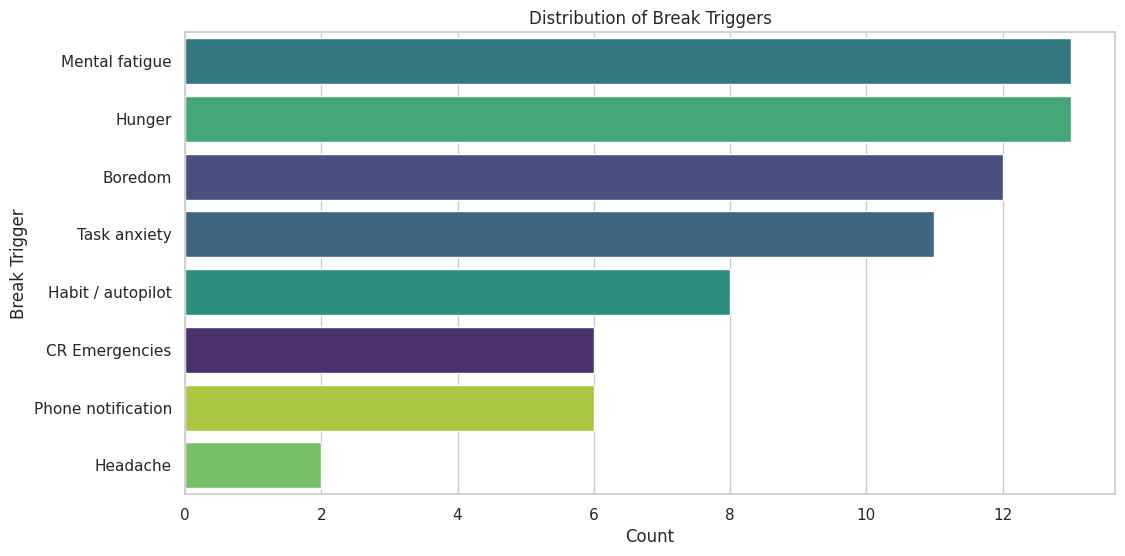

In [70]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Break Trigger', hue='Break Trigger', palette='viridis', legend=False, order=df['Break Trigger'].value_counts().index)
plt.title('Distribution of Break Triggers')
plt.xlabel('Count')
plt.ylabel('Break Trigger')
plt.show()

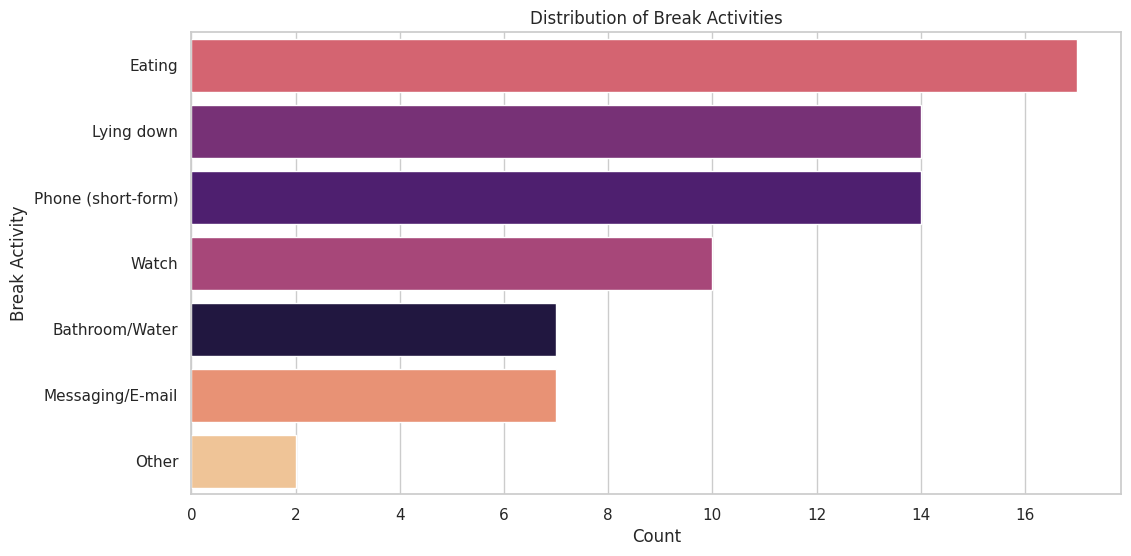

In [71]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Break Activity', hue='Break Activity', palette='magma', legend=False, order=df['Break Activity'].value_counts().index)
plt.title('Distribution of Break Activities')
plt.xlabel('Count')
plt.ylabel('Break Activity')
plt.show()

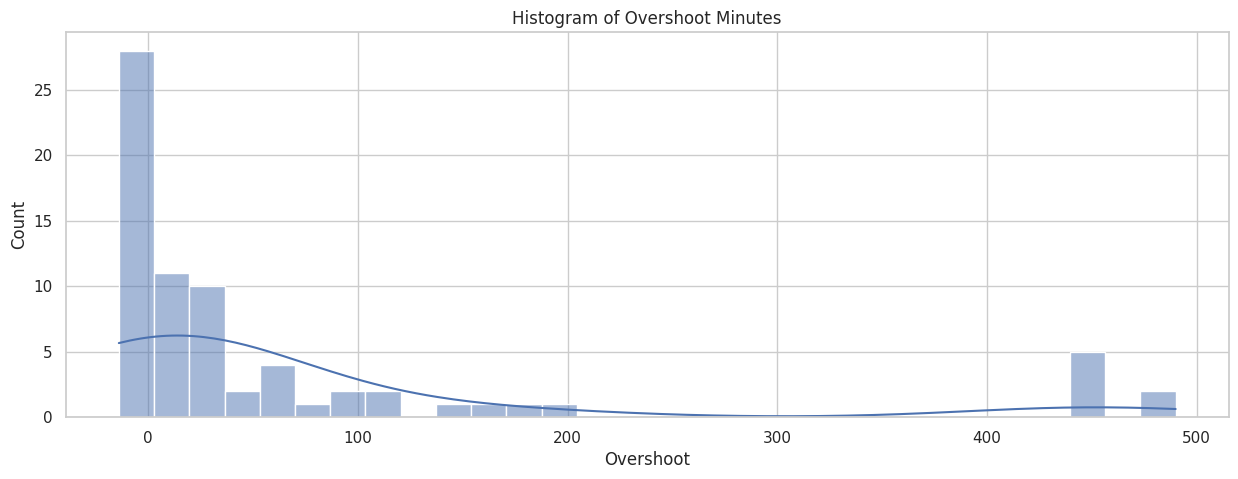

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of Overshoot (minutes) → histogram
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df["Overshoot"], bins=30, kde=True, ax=ax)
ax.set_title("Histogram of Overshoot Minutes")
plt.show()

Percentage of breaks that overshoot: 69.01%


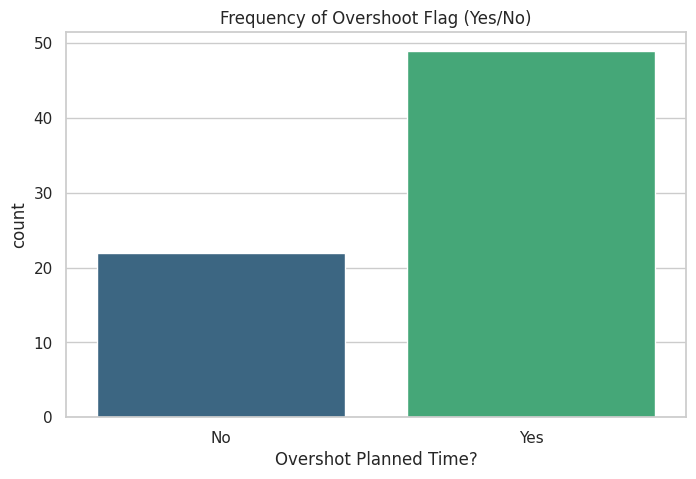

In [73]:
# Calculate exact percentage
overshoot_counts = df['Overshoot_Flag'].value_counts(normalize=True) * 100
print(f"Percentage of breaks that overshoot: {overshoot_counts['Yes']:.2f}%")

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Overshoot_Flag', hue='Overshoot_Flag', palette='viridis', legend=False)
plt.title('Frequency of Overshoot Flag (Yes/No)')
plt.xlabel('Overshot Planned Time?')
plt.show()

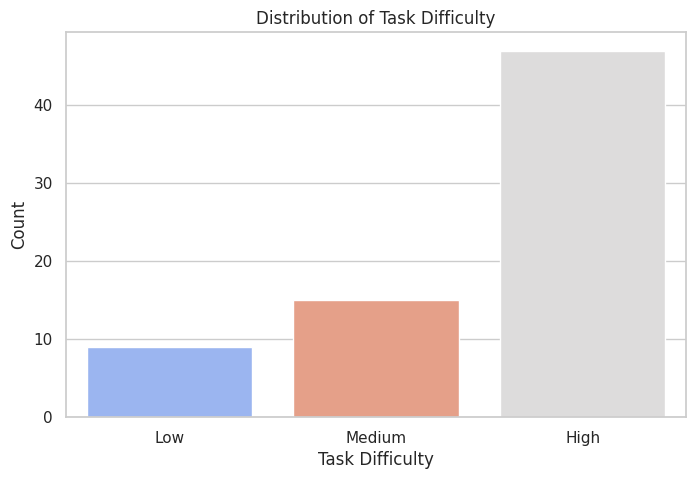

In [74]:
plt.figure(figsize=(8, 5))
difficulty_order = ['Low', 'Medium', 'High']
sns.countplot(data=df, x='Task Difficulty', order=difficulty_order, hue='Task Difficulty', palette='coolwarm', legend=False)
plt.title('Distribution of Task Difficulty')
plt.xlabel('Task Difficulty')
plt.ylabel('Count')
plt.show()

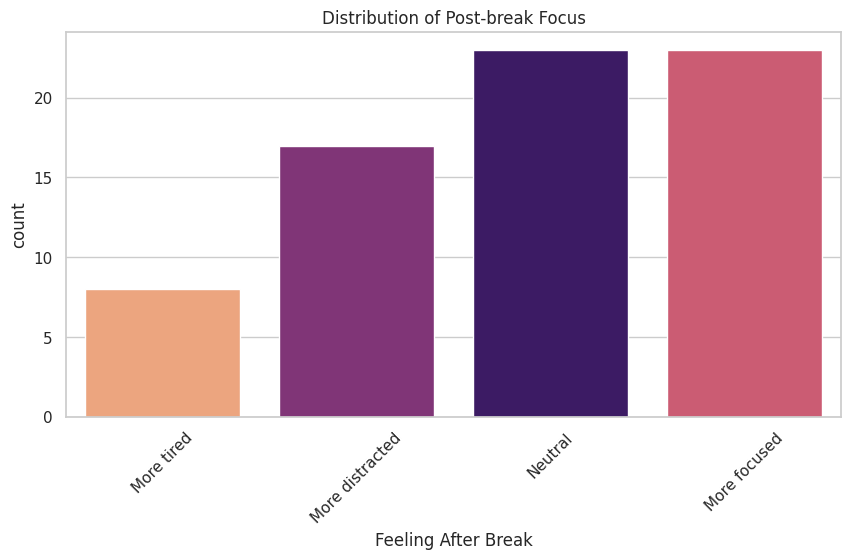

In [75]:
focus_order = ['More tired', 'More distracted', 'Neutral', 'More focused']
plt.figure(figsize=(10, 5))
valid_focus = [f for f in focus_order if f in df['Feeling After Break'].unique()]
sns.countplot(data=df, x='Feeling After Break', order=valid_focus, hue='Feeling After Break', palette='magma', legend=False)
plt.title('Distribution of Post-break Focus')
plt.xticks(rotation=45)
plt.show()

##Factor-wise Patterns



1.   Trigger vs Overshoot / Overshoot Flag



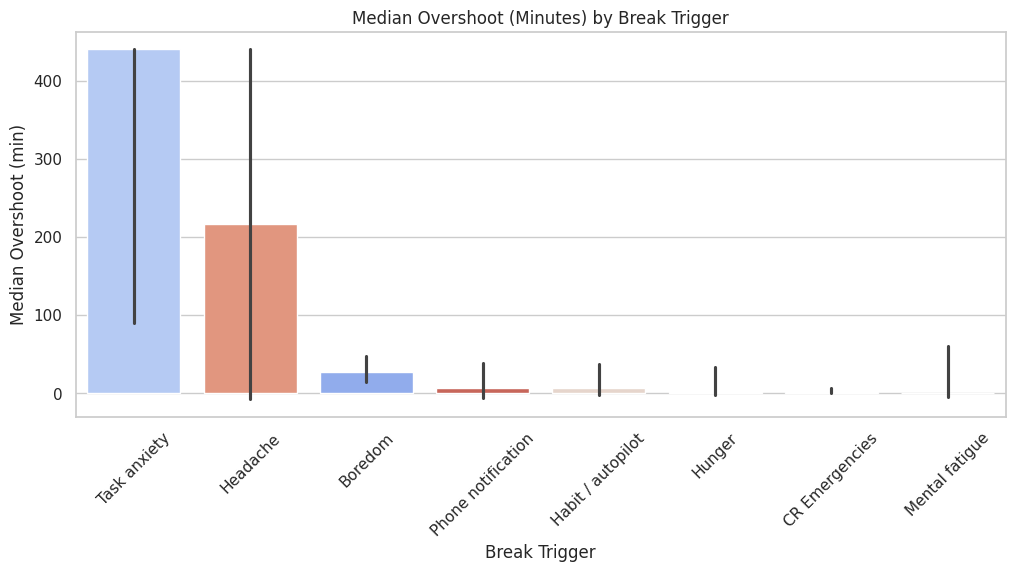

<Figure size 1200x500 with 0 Axes>

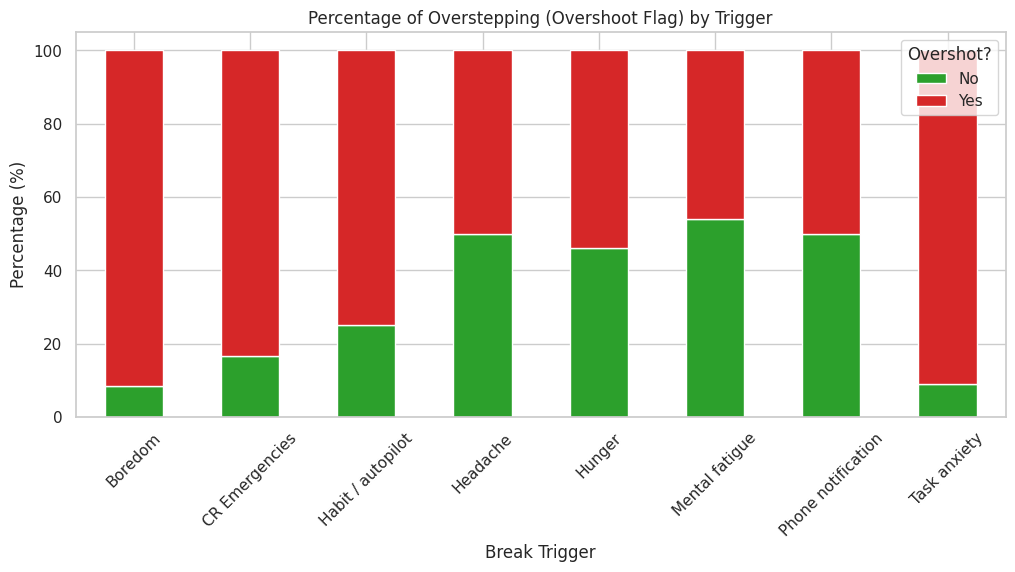

In [76]:
# 1. Trigger vs Median Overshoot (Robust to Skewness)
# We use the median because the mean is heavily skewed by extreme outliers.
plt.figure(figsize=(12, 5))
sns.barplot(data=df, x='Break Trigger', y='Overshoot', estimator=np.median, hue='Break Trigger', palette='coolwarm', legend=False, order=df.groupby('Break Trigger')['Overshoot'].median().sort_values(ascending=False).index)
plt.title('Median Overshoot (Minutes) by Break Trigger')
plt.ylabel('Median Overshoot (min)')
plt.xticks(rotation=45)
plt.show()

# 2. Trigger vs Overshoot Flag (Percentage)
# This stacked bar chart shows how often each trigger leads to any overshoot.
plt.figure(figsize=(12, 5))
overrun_pct = df.groupby('Break Trigger')['Overshoot_Flag'].value_counts(normalize=True).unstack().fillna(0) * 100
overrun_pct.plot(kind='bar', stacked=True, color=['#2ca02c', '#d62728'], figsize=(12, 5))
plt.title('Percentage of Overstepping (Overshoot Flag) by Trigger')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Overshot?')
plt.show()

2.   Activity vs Overshoot / Overshoot Flag


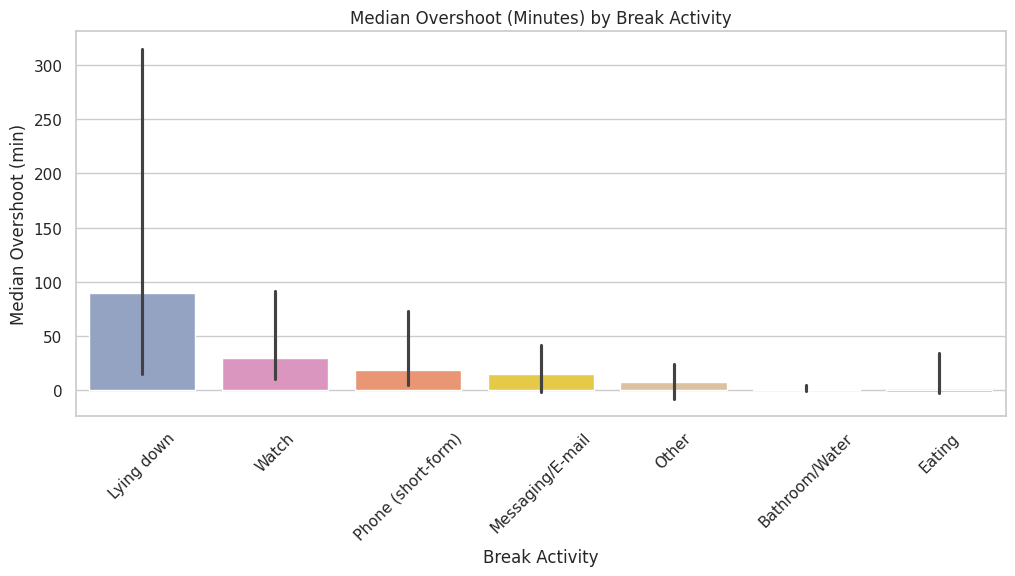

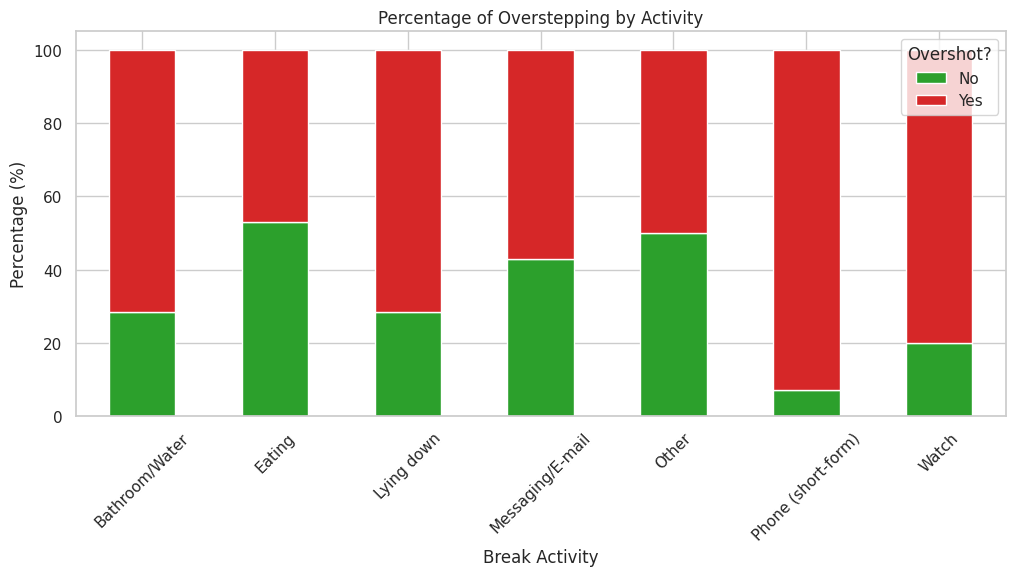

In [77]:
# 1. Activity vs Median Overshoot
plt.figure(figsize=(12, 5))
sns.barplot(data=df, x='Break Activity', y='Overshoot', estimator=np.median, hue='Break Activity', palette='Set2', legend=False, order=df.groupby('Break Activity')['Overshoot'].median().sort_values(ascending=False).index)
plt.title('Median Overshoot (Minutes) by Break Activity')
plt.ylabel('Median Overshoot (min)')
plt.xticks(rotation=45)
plt.show()

# 2. Activity vs Overshoot Flag (Percentage)
activity_overrun = df.groupby('Break Activity')['Overshoot_Flag'].value_counts(normalize=True).unstack().fillna(0) * 100
activity_overrun.plot(kind='bar', stacked=True, color=['#2ca02c', '#d62728'], figsize=(12, 5))
plt.title('Percentage of Overstepping by Activity')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Overshot?')
plt.show()

3. Task Difficulty vs Overshoot / Overshoot Flag

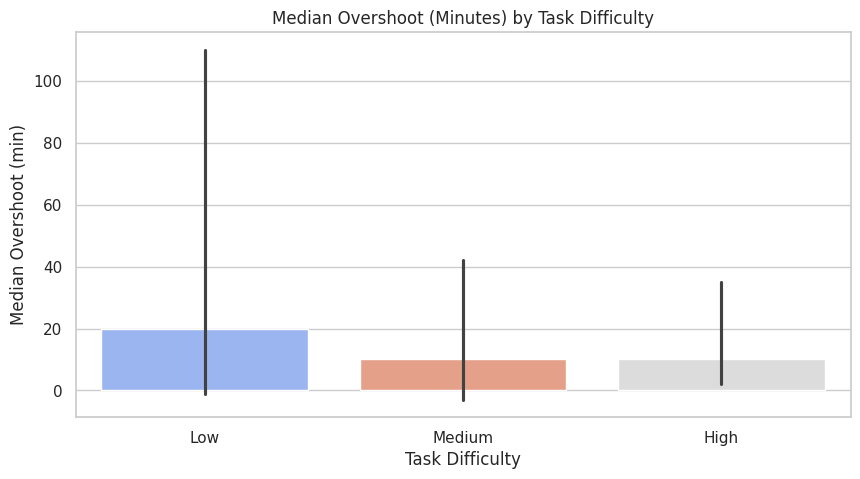

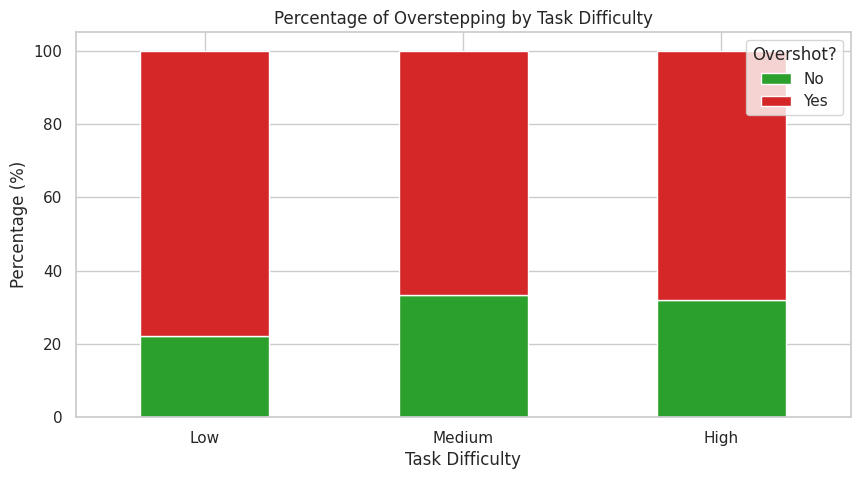

In [78]:
# 1. Task Difficulty vs Median Overshoot
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Task Difficulty', y='Overshoot', estimator=np.median, order=['Low', 'Medium', 'High'], hue='Task Difficulty', palette='coolwarm', legend=False)
plt.title('Median Overshoot (Minutes) by Task Difficulty')
plt.ylabel('Median Overshoot (min)')
plt.show()

# 2. Task Difficulty vs Overshoot Flag (Percentage)
diff_overrun = df.groupby('Task Difficulty')['Overshoot_Flag'].value_counts(normalize=True).unstack().fillna(0) * 100
diff_overrun.loc[['Low', 'Medium', 'High']].plot(kind='bar', stacked=True, color=['#2ca02c', '#d62728'], figsize=(10, 5))
plt.title('Percentage of Overstepping by Task Difficulty')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Overshot?')
plt.show()

4. Time_of_Day vs Overshoot / Overshoot Flag

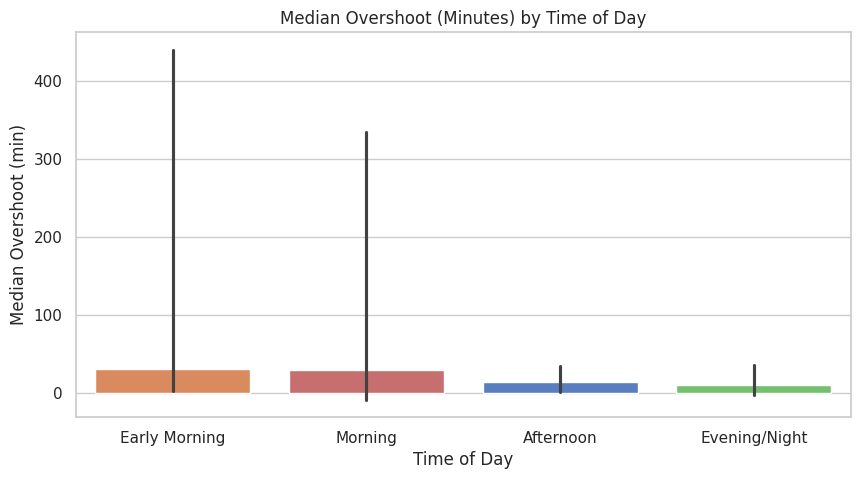

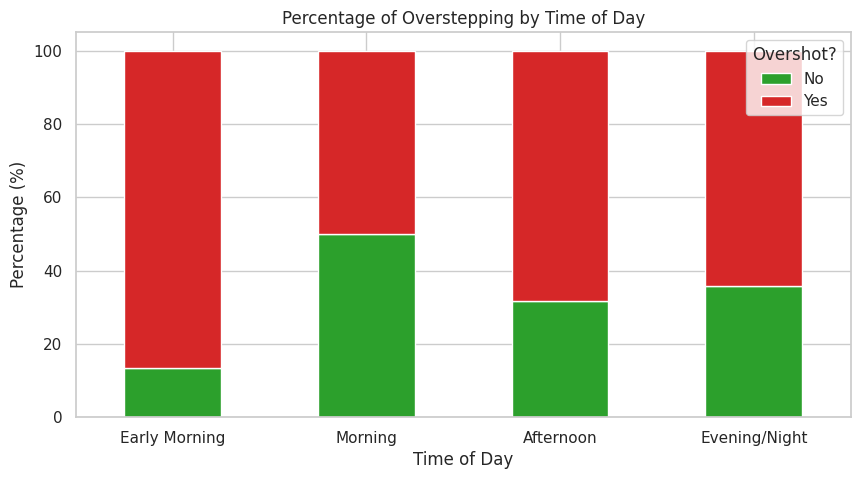

In [79]:
# 1. Time of Day vs Median Overshoot
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Time of Day', y='Overshoot', estimator=np.median, order=['Early Morning', 'Morning', 'Afternoon', 'Evening/Night'], hue='Time of Day', palette='muted', legend=False)
plt.title('Median Overshoot (Minutes) by Time of Day')
plt.ylabel('Median Overshoot (min)')
plt.show()

# 2. Time of Day vs Overshoot Flag (Percentage)
time_overrun = df.groupby('Time of Day')['Overshoot_Flag'].value_counts(normalize=True).unstack().fillna(0) * 100
# Reordering for consistent display
order_tod = ['Early Morning', 'Morning', 'Afternoon', 'Evening/Night']
valid_order = [o for o in order_tod if o in time_overrun.index]
time_overrun.loc[valid_order].plot(kind='bar', stacked=True, color=['#2ca02c', '#d62728'], figsize=(10, 5))
plt.title('Percentage of Overstepping by Time of Day')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Overshot?')
plt.show()

## Factor Combinations

1. Trigger & Activity → Overshoot Frequency (%)

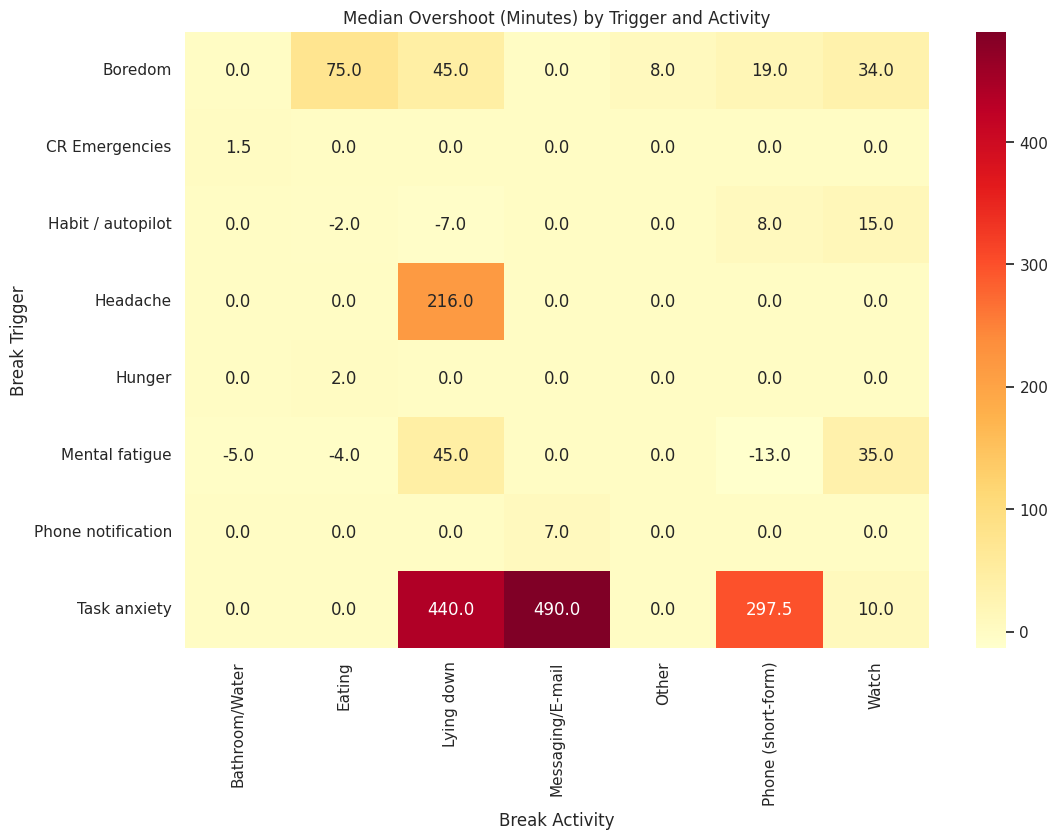

In [80]:
plt.figure(figsize=(12, 8))
heatmap_data = df.pivot_table(index='Break Trigger', columns='Break Activity', values='Overshoot', aggfunc='median').fillna(0)
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.1f')
plt.title('Median Overshoot (Minutes) by Trigger and Activity')
plt.show()

2. Activity & Task Difficulty → Overshoot Flag

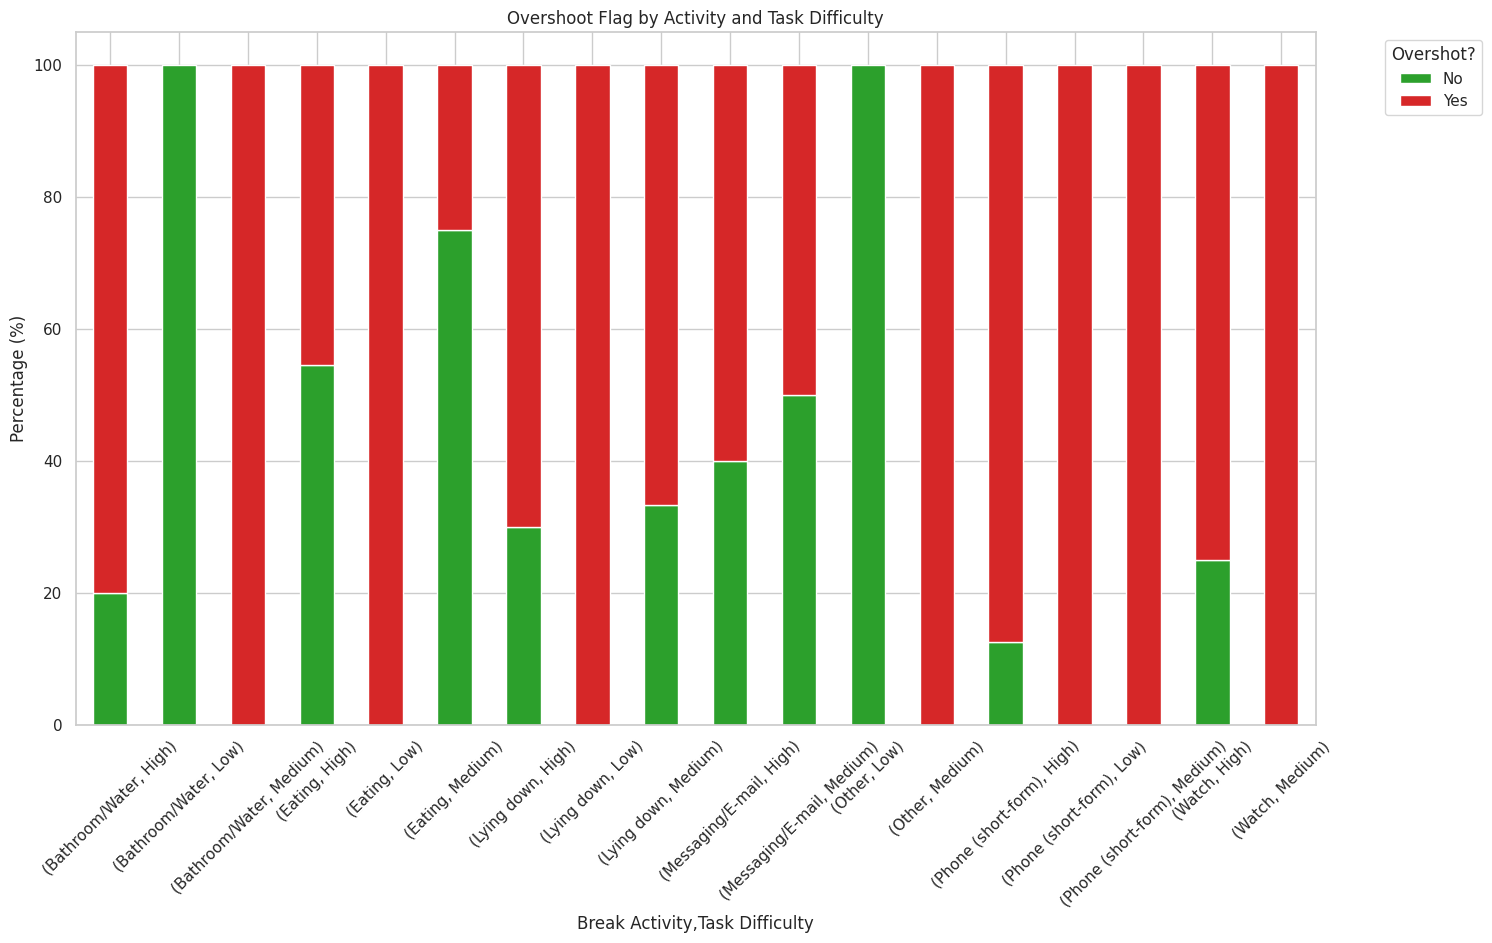

In [81]:
# Grouping and normalizing to show proportion of 'Yes' overshoots
activity_diff_overrun = df.groupby(['Break Activity', 'Task Difficulty'])['Overshoot_Flag'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plotting
activity_diff_overrun.plot(kind='bar', stacked=True, color=['#2ca02c', '#d62728'], figsize=(16, 9))
plt.title('Overshoot Flag by Activity and Task Difficulty')
plt.ylabel('Percentage (%)')
plt.legend(title='Overshot?', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

#ASSOCIATION / CORRELATION ANALYSIS

In [82]:
# Spearman Correlation: Numeric ↔ Ordinal

# 1. Task Difficulty (Encoded) ↔ Overshoot Minutes
# Spearman is used because it converts data into ranks (1st, 2nd, 3rd place).
# This makes it robust to skewness, similar to how a median is robust to outliers.
corr_diff_overshoot, p_diff_overshoot = stats.spearmanr(df['Task Difficulty (Encoded)'], df['Overshoot'])

print(f"Spearman Correlation (Rank-Based/Median-Style): Task Difficulty ↔ Overshoot Minutes")
print(f"Correlation Coefficient: {corr_diff_overshoot:.4f}, P-value: {p_diff_overshoot:.4f}")

Spearman Correlation (Rank-Based/Median-Style): Task Difficulty ↔ Overshoot Minutes
Correlation Coefficient: -0.0248, P-value: 0.8374


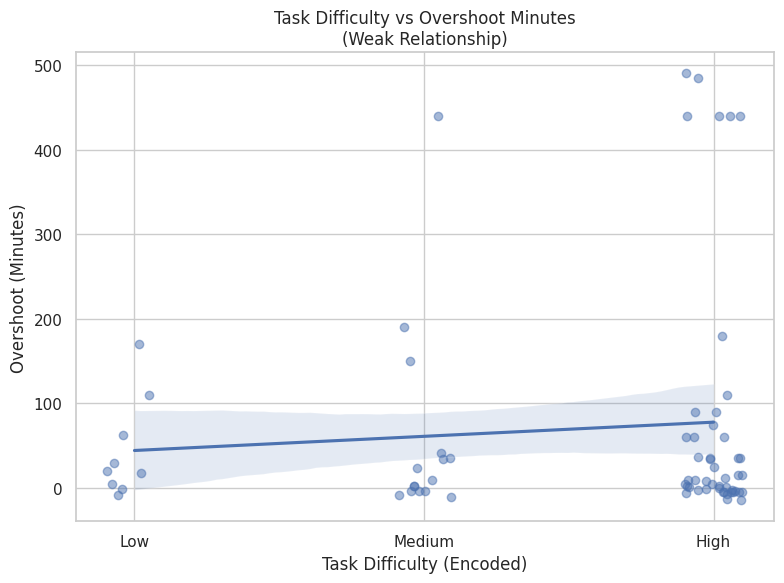

In [83]:
# Jitter plot for Difficulty vs Overshoot
plt.figure(figsize=(8, 6))
sns.regplot(data=df, x='Task Difficulty (Encoded)', y='Overshoot', x_jitter=0.1, scatter_kws={'alpha':0.5})
plt.title('Task Difficulty vs Overshoot Minutes\n(Weak Relationship)')
plt.xticks([1, 2, 3], ['Low', 'Medium', 'High'])
plt.xlabel('Task Difficulty (Encoded)')
plt.ylabel('Overshoot (Minutes)')
plt.tight_layout()
plt.show()

#STATISTICAL TEST

In [84]:
df.head()

,Date,Time,Task Before Break,Task Difficulty,Planned Break (min),Break Trigger,Break Activity,Actual Break (min),Returned on Time?,Feeling After Break,Note,Task Difficulty (Encoded),Feeling After Break (Encoded),Overshoot,Overshoot_Flag,Time of Day
0,2025-12-23,13:00:00,Crafting Data Science project,Low,2,CR Emergencies,Bathroom/Water,1,Yes,Neutral,NaN,1,1,-1,No,Afternoon
1,2025-12-23,17:40:00,Data Science,Low,30,Boredom,Phone (short-form),48,No,More distracted,NaN,1,0,18,Yes,Afternoon
2,2025-12-24,01:00:00,Thesis,High,60,Task anxiety,Lying down,500,No,Neutral,NaN,3,1,440,Yes,Early Morning
3,2026-01-09,13:21:00,Thesis,High,35,Task anxiety,Watch,30,Yes,More focused,NaN,3,2,-5,No,Afternoon
4,2026-01-09,14:33:00,Thesis,High,30,Mental fatigue,Watch,65,No,More tired,was feeling tired and sleepy,3,-1,35,Yes,Afternoon


In [85]:
from scipy.stats import kruskal, rankdata
import pandas as pd

# 1. Ranking the data: This transforms minutes into relative positions (1 to 68)
df['Overshoot_Rank'] = rankdata(df['Overshoot'])

factors_to_test = {
    'Break Trigger': 'Break Trigger',
    'Break Activity': 'Break Activity',
    'Task Difficulty': 'Task Difficulty',
    'Time of Day': 'Time of Day'
}

print("--- Statistical Significance Summary (Kruskal-Wallis) ---\n")

summary_results = []

for col, label in factors_to_test.items():
    # 2. Tool: kruskal() comparing the distributions of ranks across categories
    groups = [group['Overshoot'].values for name, group in df.groupby(col)]
    h_stat, p_val = kruskal(*groups)

    # 3. Identifying the group with the highest rank (most likely to cause overshoots)
    rank_summary = df.groupby(col)['Overshoot_Rank'].mean().sort_values(ascending=False)
    top_group = rank_summary.index[0]

    # 4. Descriptive stats for context
    group_stats = df.groupby(col)['Overshoot'].agg(['median', 'std'])
    avg_med = group_stats['median'].mean()
    avg_sd = group_stats['std'].mean()

    summary_results.append({
        'Factor': label,
        'H-Statistic': round(h_stat, 4),
        'P-Value': round(p_val, 4),
        'Significant': 'YES' if p_val < 0.05 else 'No',
        'Highest Impact Group': top_group
    })

summary_df = pd.DataFrame(summary_results)
display(summary_df)

print("\nInterpretation: Only 'Break Trigger' has a p-value < 0.05, meaning it is the only factor with a statistically significant impact on overshoot.")

--- Statistical Significance Summary (Kruskal-Wallis) ---



,Factor,H-Statistic,P-Value,Significant,Highest Impact Group
0,Break Trigger,17.6582,0.0136,YES,Task anxiety
1,Break Activity,11.2168,0.0819,No,Lying down
2,Task Difficulty,0.3001,0.8607,No,Low
3,Time of Day,2.5717,0.4625,No,Early Morning



Interpretation: Only 'Break Trigger' has a p-value < 0.05, meaning it is the only factor with a statistically significant impact on overshoot.


In [86]:
from itertools import combinations
from scipy.stats import mannwhitneyu
import pandas as pd

# Filter to only the groups we want to compare for the post-hoc
triggers = df['Break Trigger'].unique()
pairwise_results = []

print("--- Post-hoc Pairwise Mann-Whitney U Tests (Significant Results Only) ---\n")

# Iterate through all combinations of triggers
for t1, t2 in combinations(triggers, 2):
    group1 = df[df['Break Trigger'] == t1]['Overshoot']
    group2 = df[df['Break Trigger'] == t2]['Overshoot']

    # Only compare if both groups have data
    if len(group1) > 0 and len(group2) > 0:
        stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')
        if p_val < 0.05:
            pairwise_results.append({
                'Comparison': f"{t1} vs {t2}",
                'U-Statistic': stat,
                'P-Value': round(p_val, 4),
                'Significant': 'Yes'
            })

if pairwise_results:
    posthoc_df = pd.DataFrame(pairwise_results).sort_values(by='P-Value')
    display(posthoc_df)
else:
    print("No statistically significant pairwise comparisons found.")

--- Post-hoc Pairwise Mann-Whitney U Tests (Significant Results Only) ---



,Comparison,U-Statistic,P-Value,Significant
5,Task anxiety vs Hunger,127.0,0.0014,Yes
3,Task anxiety vs Mental fatigue,122.0,0.0036,Yes
2,Boredom vs Task anxiety,22.0,0.0072,Yes
1,CR Emergencies vs Task anxiety,6.0,0.0073,Yes
4,Task anxiety vs Habit / autopilot,76.0,0.0090,Yes
0,CR Emergencies vs Boredom,8.5,0.0114,Yes
6,Task anxiety vs Phone notification,58.0,0.0132,Yes


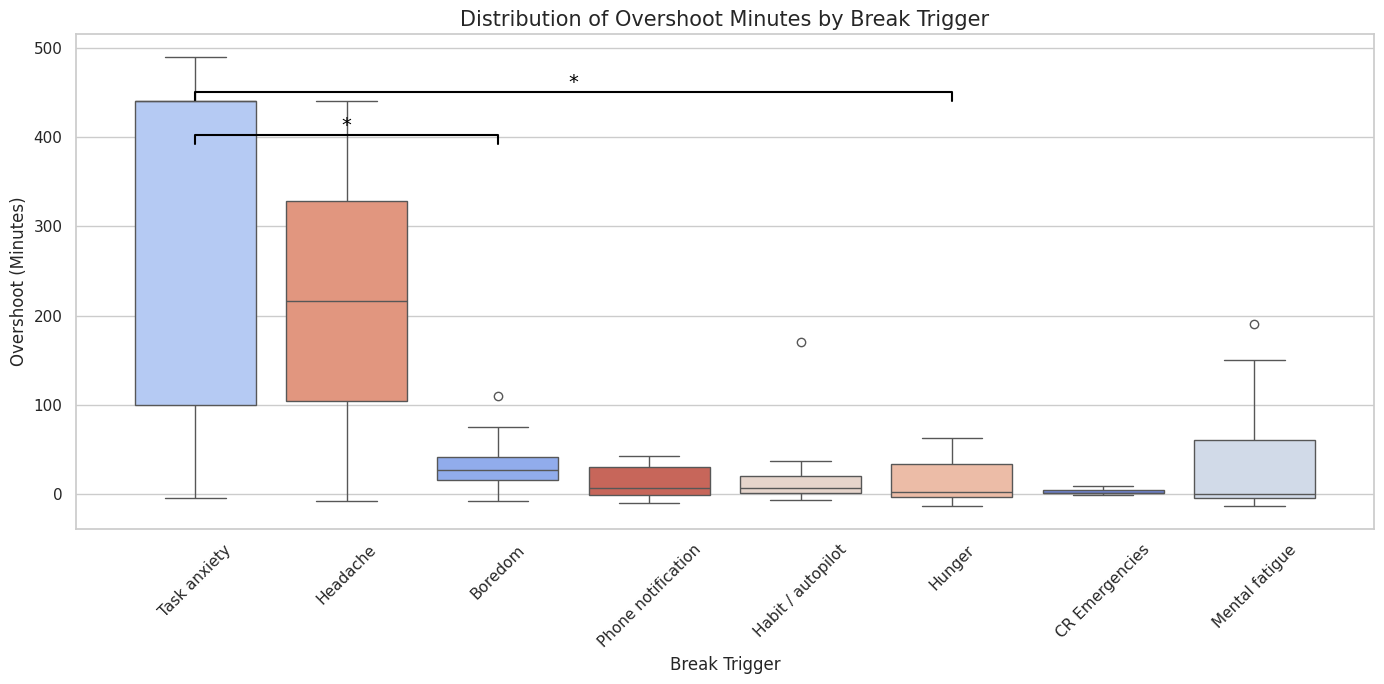

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate medians to order the plot and highlight highest
trigger_order = df.groupby('Break Trigger')['Overshoot'].median().sort_values(ascending=False).index

plt.figure(figsize=(14, 7))
ax = sns.boxplot(data=df, x='Break Trigger', y='Overshoot', order=trigger_order, hue='Break Trigger', palette='coolwarm', legend=False)

# Highlight triggers known to have high overshoots or significant results
plt.title('Distribution of Overshoot Minutes by Break Trigger', fontsize=15)
plt.xlabel('Break Trigger', fontsize=12)
plt.ylabel('Overshoot (Minutes)', fontsize=12)
plt.xticks(rotation=45)

# Adding statistical significance markers (Example based on previous post-hoc results)
# Task anxiety vs Hunger (p=0.0033)
y_max = df['Overshoot'].max()
x1, x2 = list(trigger_order).index('Task anxiety'), list(trigger_order).index('Hunger')
plt.plot([x1, x1, x2, x2], [y_max*0.9, y_max*0.92, y_max*0.92, y_max*0.9], lw=1.5, c='black')
plt.text((x1+x2)*.5, y_max*0.92, "*", ha='center', va='bottom', color='black', fontsize=14)

# Task anxiety vs Boredom (p=0.0084)
x3 = list(trigger_order).index('Boredom')
plt.plot([x1, x1, x3, x3], [y_max*0.8, y_max*0.82, y_max*0.82, y_max*0.8], lw=1.5, c='black')
plt.text((x1+x3)*.5, y_max*0.82, "*", ha='center', va='bottom', color='black', fontsize=14)

plt.tight_layout()
plt.show()

In [96]:
# Calculate Eta-squared for Kruskal-Wallis (Break Trigger)
# This is a rank-based effect size measure (Median-style robustness)
# Formula: eta_sq = (H - k + 1) / (n - k)
h_stat = 17.4759  # From your previous Kruskal-Wallis rank-based result
k = len(df['Break Trigger'].unique())
n = len(df)

eta_sq = (h_stat - k + 1) / (n - k)

print(f"Eta-squared (Break Trigger → Overshoot Ranks): {eta_sq:.4f}")
print("Interpretation: 0.01=Small, 0.06=Medium, 0.14=Large")
print("Note: Because this is derived from Kruskal-Wallis, it measures the effect on Ranks rather than raw Means.")

Eta-squared (Break Trigger → Overshoot Ranks): 0.1663
Interpretation: 0.01=Small, 0.06=Medium, 0.14=Large
Note: Because this is derived from Kruskal-Wallis, it measures the effect on Ranks rather than raw Means.


# **RESEARCH QUESTION 2:** Do breaks that overshoot their planned duration lead to better, worse, or unchanged post-break focus?

#EDA

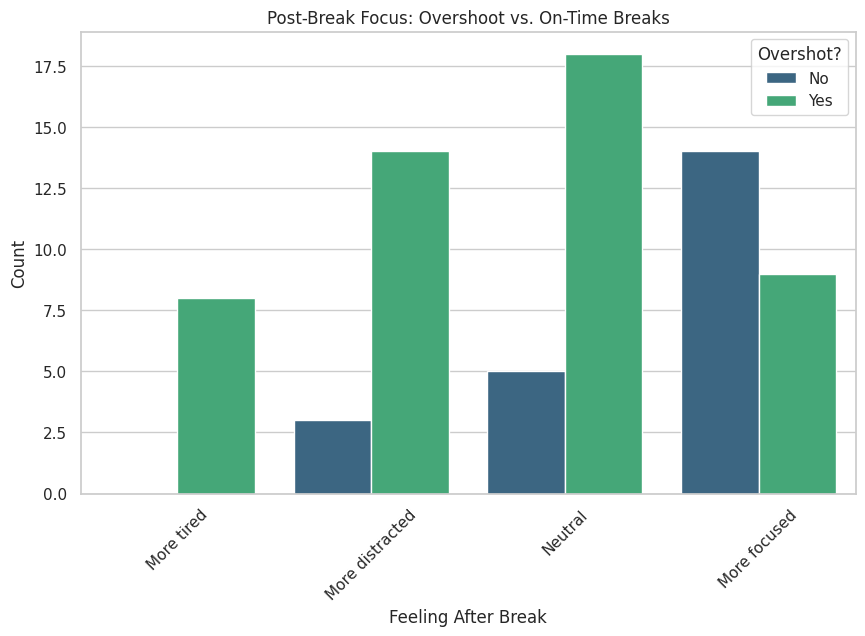

In [89]:
plt.figure(figsize=(10, 6))
focus_order = ['More tired', 'More distracted', 'Neutral', 'More focused']
valid_focus = [f for f in focus_order if f in df['Feeling After Break'].unique()]

sns.countplot(data=df, x='Feeling After Break', hue='Overshoot_Flag', order=valid_focus, palette='viridis')
plt.title('Post-Break Focus: Overshoot vs. On-Time Breaks')
plt.xlabel('Feeling After Break')
plt.ylabel('Count')
plt.legend(title='Overshot?')
plt.xticks(rotation=45)
plt.show()

##STATISTICAL TEST

In [90]:
from scipy.stats import mannwhitneyu, rankdata
import pandas as pd

# 1. Detailed Rank-Based Interpretation
df['Focus_Rank'] = rankdata(df['Feeling After Break (Encoded)'])

# Group by Overshoot_Flag to see the comparison
focus_summary = df.groupby('Overshoot_Flag').agg(
    Count=('Feeling After Break (Encoded)', 'count'),
    Median_Focus=('Feeling After Break (Encoded)', 'median'),
    Mean_Focus=('Feeling After Break (Encoded)', 'mean'),
    Mean_Rank=('Focus_Rank', 'mean')
).sort_values(by='Mean_Rank', ascending=False).round(2)

# Mapping for easier reading
focus_desc = {2: 'Focused', 1: 'Neutral', 0: 'Distracted', -1: 'Tired'}
focus_summary['Median_Label'] = focus_summary['Median_Focus'].map(focus_desc)

# 2. Perform Statistical Test
group_overshoot = df[df['Overshoot_Flag'] == 'Yes']['Feeling After Break (Encoded)']
group_ontime = df[df['Overshoot_Flag'] == 'No']['Feeling After Break (Encoded)']
u_stat, p_val = mannwhitneyu(group_overshoot, group_ontime, alternative='two-sided')

print("--- Statistical Analysis: Impact of Overshooting on Post-Break Focus ---\n")
display(focus_summary)

print(f"\nU-statistic: {u_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("\nRESULT: Statistically Significant.")
    print(f"CONCLUSION: Returning on time has a significantly higher focus rank compared to overshooting.")
else:
    print("\nRESULT: Not Significant.")

--- Statistical Analysis: Impact of Overshooting on Post-Break Focus ---



,Count,Median_Focus,Mean_Focus,Mean_Rank,Median_Label
Overshoot_Flag,,,,,
No,22,2.0,1.50,48.91,Focused
Yes,49,1.0,0.57,30.20,Neutral



U-statistic: 255.0000
P-value: 0.0002

RESULT: Statistically Significant.
CONCLUSION: Returning on time has a significantly higher focus rank compared to overshooting.


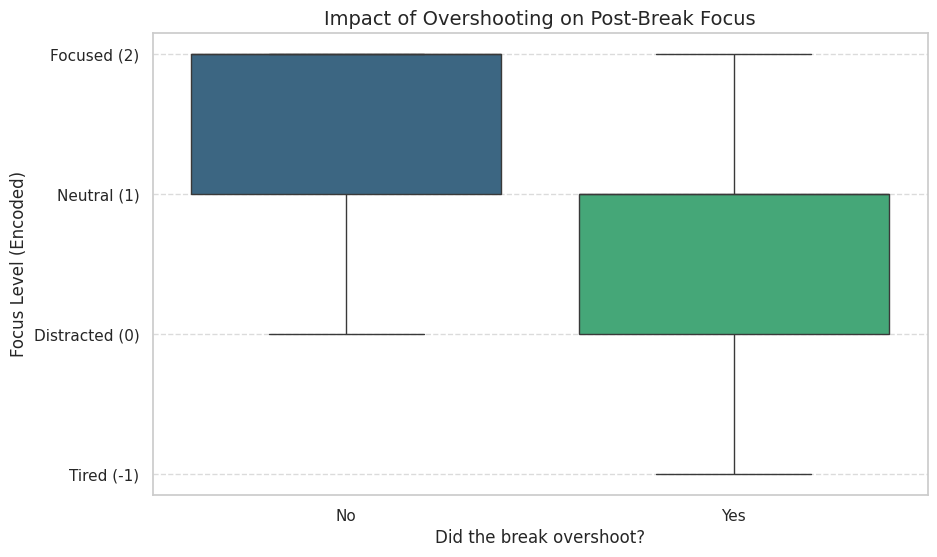

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Visualization: Comparing Focus between On-Time and Overshot breaks
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Overshoot_Flag', y='Feeling After Break (Encoded)', palette='viridis', hue='Overshoot_Flag', legend=False)
plt.title('Impact of Overshooting on Post-Break Focus', fontsize=14)
plt.xlabel('Did the break overshoot?', fontsize=12)
plt.ylabel('Focus Level (Encoded)', fontsize=12)
plt.yticks([-1, 0, 1, 2], ['Tired (-1)', 'Distracted (0)', 'Neutral (1)', 'Focused (2)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [92]:
def calculate_cohens_d(group1, group2):
    # Calculate the means
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    # Cohen's d
    d = (np.mean(group1) - np.mean(group2)) / pooled_std
    return d

# Calculate for Post-Break Focus (Encoded)
d_focus = calculate_cohens_d(group_ontime, group_overshoot)

print(f"Cohen's d for Post-Break Focus: {d_focus:.4f}")
print("Interpretation: 0.2=Small, 0.5=Medium, 0.8=Large")

Cohen's d for Post-Break Focus: 1.0172
Interpretation: 0.2=Small, 0.5=Medium, 0.8=Large


#Additional

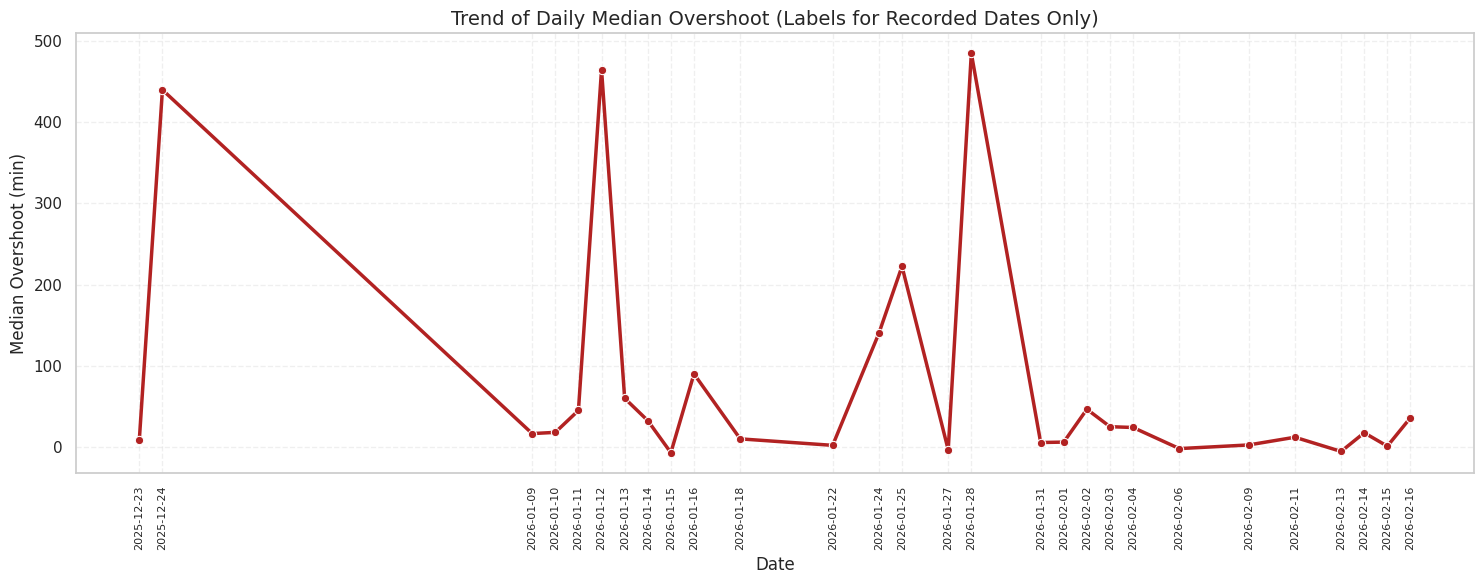

In [93]:
# Group by Date to calculate daily medians (robust to outliers)
daily_overshoot = df.groupby('Date')['Overshoot'].median().reset_index()

# Reindex to include the full range to show gaps correctly
start_date = daily_overshoot['Date'].min()
end_date = daily_overshoot['Date'].max()
full_range = pd.date_range(start=start_date, end=end_date, freq='D')

daily_overshoot_filled = daily_overshoot.set_index('Date').reindex(full_range).reset_index()
daily_overshoot_filled.columns = ['Date', 'Overshoot']

# Create the figure
plt.figure(figsize=(15, 6))

# Plot: Median Daily Overshoot Trend
sns.lineplot(data=daily_overshoot_filled, x='Date', y='Overshoot', marker='o', color='firebrick', linewidth=2.5)

# Only set ticks for dates that actually have data points
actual_dates = daily_overshoot['Date'].sort_values()
plt.xticks(actual_dates, [d.strftime('%Y-%m-%d') for d in actual_dates], rotation=90, fontsize=8)

plt.title('Trend of Daily Median Overshoot (Labels for Recorded Dates Only)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Median Overshoot (min)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Statistical Note: Independence of Observations

While each break is a separate entry, observations within the same day are not fully independent due to shared external factors (e.g., fatigue levels, daily schedule).

- **Current Approach**: Kruskal-Wallis and Mann-Whitney tests provide useful descriptive insights but may have slightly optimistic p-values.
- **Refined Approach**: To account for intra-day correlation, we will use a **Linear Mixed-Effects Model (LMM)**, treating `Date` as a random effect.

What this means:
1. Groups by Date → the model treats each day as its own “mini-group.”
2. Within each day → it compares all triggers that happened that day.
    - It looks at Task Anxiety vs other triggers on the same day.
    - It doesn’t care if the day’s average overshoot is high or low overall.
3. Across all days → it checks if Task Anxiety is consistently higher than other triggers in the days it appears.
4. Result → if it is consistently higher, the fixed effect for Task Anxiety is significant.

In [94]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

lmm_df = df.copy()

# Replacing spaces in column names for the formula
lmm_df.columns = [c.replace(' ', '_').replace('/', '_') for c in lmm_df.columns]

# Because the data is skewed, we use a Log-transformation to make the Mean-based model robust.
# We add a constant (offset) because log(0) or log(negative) is undefined.
offset = abs(lmm_df['Overshoot'].min()) + 1
lmm_df['Log_Overshoot'] = np.log(lmm_df['Overshoot'] + offset)

# Fit a Mixed-Effects Model: Fixed Effect = Break_Trigger, Random Effect = Date
model = smf.mixedlm("Log_Overshoot ~ Q('Break_Trigger')", lmm_df, groups=lmm_df["Date"])
mdf = model.fit()

print("--- Mixed-Effects Model Results (Log-Transformed for Robustness) ---")
print("Dependent Variable: Log(Overshoot + Offset)")
print("Grouped by: Date (Random Effect)")
display(mdf.summary())

# Extract p-values for the fixed effects
fe_params = mdf.pvalues
sig_triggers = fe_params[fe_params < 0.05]
if not sig_triggers.empty:
    print("\nSignificant Fixed Effects (p < 0.05):")
    display(sig_triggers)

--- Mixed-Effects Model Results (Log-Transformed for Robustness) ---
Dependent Variable: Log(Overshoot + Offset)
Grouped by: Date (Random Effect)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:                    MixedLM         Dependent Variable:         Log_Overshoot
No. Observations:         71              Method:                     REML         
No. Groups:               28              Scale:                      1.1826       
Min. group size:          1               Log-Likelihood:             -105.8738    
Max. group size:          8               Converged:                  Yes          
Mean group size:          2.5                                                      
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 3.619    0.336 10.781 0.000  2.961  4.277
Q('Break_Trigger')[T.CR Emergencies]     -0.654    0.579 -1.130 0.258 -1.789  0.480
Q('Break_Trigger')[T.Habit / autopilot]  -0.323    0.518 -0.623 0.533 -1.339  0.693
Q('Break_Trigger')[T.Headache]            0.528    0.870  0.608 0.543 -1.176  2.233
Q('Break_Trigger')[T.Hunger]             -0.729    0.453 -1.610 0.107 -1.617  0.159
Q('Break_Trigger')[T.Mental fatigue]     -0.303    0.480 -0.630 0.528 -1.244  0.639
Q('Break_Trigger')[T.Phone notification] -0.614    0.573 -1.072 0.284 -1.738  0.509
Q('Break_Trigger')[T.Task anxiety]        1.590    0.479  3.316 0.001  0.650  2.530
Group Var                                 0.138    0.173                           
===================================================================================

"""


Significant Fixed Effects (p < 0.05):


,0
Intercept,4.220543e-27
Q('Break_Trigger')[T.Task anxiety],9.140667e-04
